In [234]:
import torch 
from torch.utils.data import Dataset
from dataclasses import dataclass
import matplotlib.pyplot as plt
import fastjet as fj
import h5py
import pandas as pd
import numpy as np

### N-subjettiness

In [235]:
# TODO - add tau minimization as in the paper

def get_N_axes(jet, N, R=1.0):
    """
    Calculate the N exclusive axes for a given jet using the kT algorithm.

    Parameters:
    - jet: the jet for which to calculate axes.
    - N: the number of axes to calculate.
    - R: the jet radius parameter for the clustering algorithm.
    
    Returns:
    - A list of axes (pseudojets).
    """
    constituents = [fj.PseudoJet(c.px(), c.py(), c.pz(), c.e()) for c in jet.constituents()]
    axesdef = fj.JetDefinition(fj.kt_algorithm, 1000)
    cluster = fj.ClusterSequence(constituents, axesdef)
    return cluster.exclusive_jets(N)

def N_subjettiness(jet, N, R=1.0, beta=1.0):
    """
    Calculate the N-subjettiness value for a given jet and set of axes.

    Parameters:
    - axes: the axes around which to calculate tau_N.
    - jet: the jet for which to calculate tau_N.
    - R: the jet radius parameter for the clustering algorithm.
    - beta: the angular exponent in the N-subjettiness calculation.
    
    Returns:
    - The tau_N 
    """

    axes = get_N_axes(jet, N, R) 
    tau_N = 0.0
    d0 = 0.0
    for c in jet.constituents():
        tau_N += c.pt() * min([c.delta_R(ax)**beta for ax in axes])
        d0 += c.pt() * (R**beta)
    return tau_N / d0 

# LHC Olympics: cluster jets

Cluster jets and compute high-level features

In [236]:
def get_constituents(jet, relative_coords=True, max_particles=100):
    pt = jet.pt()
    eta = jet.eta()
    phi = jet.phi()
    constituents = []
    N = len(jet.constituents())
        
    for c in jet.constituents():
        feats = [c.pt() / pt, eta - c.eta(), phi - c.phi(), 1] if relative_coords else [c.pt(), c.eta(), c.phi(), 1]  # masked
        constituents += [feats]

    constituents = np.array(constituents)
    constituents = constituents[constituents[:,0].argsort()[::-1]]
    assert N <= max_particles, "Number of particles in jet is greater than max_particles"
    constituents = np.pad(constituents, ((0, max_particles - N), (0,0)), 'constant')

    return constituents

def get_dijet_dataset_low_level(file, particle_level=False, stop=None, jet_algorithm='antikt', R=1.0, pt_jet_min=20.0, max_particles=280):

    data = pd.read_hdf(file,  stop=stop).to_numpy()
    events = data[..., :-1].reshape(data.shape[0], 700, -1)
    labels = data[..., -1]
    jet_features = []
    particle_features = []

    for event in events:
        event = event[event[:,0] != 0]

        pseudojets = []
        for particle in event:
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(particle[0], particle[1], particle[2], 0.0)
            pseudojets.append(pj)

        if jet_algorithm=='antikt': algorithm = fj.antikt_algorithm
        elif jet_algorithm=='cambridge': algorithm = fj.cambridge_algorithm
        elif jet_algorithm=='kt': algorithm = fj.kt_algorithm

        jetdef = fj.JetDefinition(algorithm, R)
        cluster = fj.ClusterSequence(pseudojets, jetdef)
        jets = fj.sorted_by_pt(cluster.inclusive_jets(pt_jet_min))
 
        if len(jets)>=2:
            j0, j1 = jets[0], jets[1]
            N0 = len(j0.constituents())
            N1 = len(j1.constituents())

            jet_features.append([(j0 + j1).m(), j0.delta_R(j1), 
                                j0.pt(), j0.eta(), j0.phi(), j0.m(), N0,
                                j1.pt(), j1.eta(), j1.phi(), j1.m(), N1])

            if particle_level:
                consitutents_1 = get_constituents(j0, max_particles=max_particles)
                consitutents_2 = get_constituents(j1, max_particles=max_particles)
                particle_features.append(np.concatenate([consitutents_1, consitutents_2], axis=-1))
        
    # save jets:
    with h5py.File('../data/LHCOlympics2020/events_anomalydetection_low_level.h5', 'w') as f:
        jet_features = np.array(jet_features)
        jet_features = np.concatenate([labels[:, None], jet_features], axis=-1)
        f.create_dataset('jet features', data=jet_features)
        
        if particle_level: 
            particle_features = np.array(particle_features)
            f.create_dataset('particle features', data=particle_features)

def get_dijet_dataset_high_level(file, 
                                stop=None, 
                                jet_level=None, 
                                particle_level=False, 
                                jet_algorithm='antikt', 
                                R=1.0, 
                                pt_jet_min=20.0, 
                                max_particles=280):

    data = pd.read_hdf(file,  stop=stop).to_numpy()
    events = data[..., :-1].reshape(data.shape[0], 700, -1)
    labels = data[..., -1]
    jet_features = []
    jet_features_cathode = []
    particle_features = []

    for event in events:
        event = event[event[:,0] != 0]

        pseudojets = []
        for particle in event:
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(particle[0], particle[1], particle[2], 0.0)
            pseudojets.append(pj)

        if jet_algorithm=='antikt': algorithm = fj.antikt_algorithm
        elif jet_algorithm=='cambridge': algorithm = fj.cambridge_algorithm
        elif jet_algorithm=='kt': algorithm = fj.kt_algorithm

        jetdef = fj.JetDefinition(algorithm, R)
        cluster = fj.ClusterSequence(pseudojets, jetdef)
        jets = fj.sorted_by_pt(cluster.inclusive_jets(pt_jet_min))
 
        if len(jets)>=2:

            j0, j1 = jets[0], jets[1]
            N0 = len(j0.constituents())
            N1 = len(j1.constituents())
            tau1_0, tau1_1 = N_subjettiness(j0, 1, R) if N0 > 0 else 0, N_subjettiness(j1, 1, R) if N1 > 0 else 0
            tau2_0, tau2_1 = N_subjettiness(j0, 2, R) if N0 > 1 else 0, N_subjettiness(j1, 2, R) if N1 > 1 else 0
            tau3_0, tau3_1 = N_subjettiness(j0, 3, R) if N0 > 2 else 0, N_subjettiness(j1, 3, R) if N1 > 2 else 0

            jet_features.append([j0.px(), j0.py(), j0.pz(), j0.m(), tau1_0, tau2_0, tau3_0, N0,
                                 j1.px(), j1.py(), j1.pz(), j1.m(), tau1_1, tau2_1, tau3_1, N1])
            
            jet_features_cathode.append([(j0 + j1).m(), j0.delta_R(j1), j0.m(), j0.m() - j1.m(), tau2_0 / tau1_0,  tau2_1 / tau1_1])
            consitutents_1 = get_constituents(j0, max_particles=max_particles)
            consitutents_2 = get_constituents(j1, max_particles=max_particles)
            particle_features.append(np.concatenate([consitutents_1, consitutents_2], axis=-1))

    jet_features = np.array(jet_features_cathode) if jet_level == 'cathode' else np.array(jet_features) 
    jet_features = np.concatenate([labels[:, None], jet_features], axis=-1)
    particle_features = np.array(particle_features)

    # save jets:
    with h5py.File('../data/LHCOlympics2020/events_anomalydetection_high_level.h5', 'w') as f:
        f.create_dataset('jet features', data=jet_features)
        if particle_level: f.create_dataset('particle features', data=particle_features)


In [ ]:
get_dijet_dataset_low_level(file='../data/LHCOlympics2020/events_anomalydetection.h5', 
                            stop=500000, 
                            jet_algorithm='antikt', 
                            R=1.0, 
                            pt_jet_min=20.0, 
                            max_particles=275)

### get jets from h5 file

In [6]:
file = '../data/LHCOlympics2020/events_anomalydetection_dijets_high_level.h5'
f = h5py.File(file, 'r') 
dijets = f['dijet features']
jets = f['jet features']
# particles = f['particle features']

In [183]:
import pandas as pd
file = '../data/LHCOlympics2020/events_anomalydetection_v2.features.h5'
df = pd.read_hdf(file,  stop=1000000)
print(df)

               pxj1         pyj1         pzj1         mj1      tau1j1  \
0      -1467.239990   611.502014   511.101990   38.896000    8.290660   
1      -1211.239990   347.315002   547.963013  389.532013  191.804001   
2      -1229.619995   649.857971     8.089170   72.155502   47.168098   
3       -693.304016 -1046.729980  1716.910034   55.797798   24.788601   
4      -1488.199951   -25.370100   -30.989700   84.891502   26.878799   
...             ...          ...          ...         ...         ...   
999995  -286.550995 -1310.829956 -1510.910034  147.516998   60.997799   
999996   918.562988   951.195984 -1622.569946   32.242199    5.894100   
999997  1447.219971  -547.710999   827.945007  396.112000  181.406998   
999998   200.035995 -1252.869995    27.924900  363.790985  139.281998   
999999  -811.379028  1050.810059     5.019200  150.214996   92.509003   

            tau2j1     tau3j1         pxj2         pyj2         pzj2  \
0         4.836080   4.260190  1403.579956  -674.55

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:34: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].hist(jets[...,6][mask]/jets[...,5][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:35: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].hist(jets[...,14][mask]/jets[...,13][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:41: RuntimeWarning: invalid value encountered in divide
  axs[1, 1].hist(jets[...,7][mask]/jets[...,6][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:42: RuntimeWarning: invalid value encountered in divide
  axs[1, 1].hist(jets[...,15][mask]/jets[...,14][mask], bins=40, histtype=

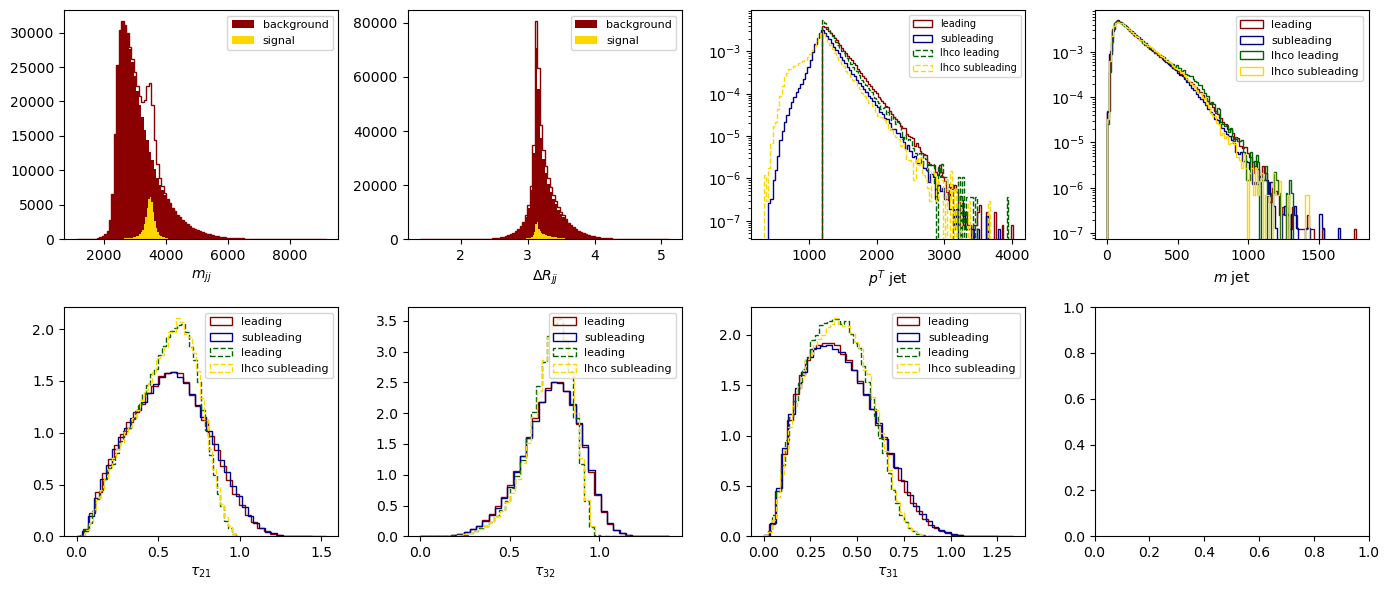

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(14, 6))

b = dijets[...,0]==0
s = dijets[...,0]==1

axs[0, 0].hist(dijets[...,1], bins=100, histtype='step', color='darkred')
axs[0, 0].hist(dijets[...,1][b], bins=100, histtype='stepfilled', color='darkred', label='background')
axs[0, 0].hist(dijets[...,1][s], bins=100, histtype='stepfilled', color='gold', label='signal')
axs[0, 0].set_xlabel(r'$m_{jj}$')
axs[0, 0].legend(fontsize=8, loc='upper right')

axs[0, 1].hist(dijets[...,2], bins=100, histtype='step', color='darkred')
axs[0, 1].hist(dijets[...,2][b], bins=100, histtype='stepfilled', color='darkred', label='background')
axs[0, 1].hist(dijets[...,2][s], bins=100, histtype='stepfilled', color='gold', label='signal')
axs[0, 1].set_xlabel(r'$\Delta R_{jj}$')
axs[0, 1].legend(fontsize=8, loc='upper right')

mask = jets[...,0]==0

axs[0, 2].hist(np.sqrt(jets[...,1][mask]**2 + jets[...,2][mask]**2) , bins=100, histtype='step', color='darkred', label='leading', log=True, density=True)
axs[0, 2].hist(np.sqrt(jets[...,9][mask]**2 + jets[...,10][mask]**2), bins=100, histtype='step', color='darkblue', label='subleading', log=True, density=True)
axs[0, 2].hist(np.sqrt(df['pxj1']**2 + df['pyj1']**2), bins=100, histtype='step', color='darkgreen', ls='--', label='lhco leading', log=True, density=True)
axs[0, 2].hist(np.sqrt(df['pxj2']**2 + df['pyj2']**2), bins=100, histtype='step', color='gold',ls='--',label='lhco subleading', log=True, density=True)
axs[0, 2].set_xlabel(r'$p^T$ jet')
axs[0, 2].legend(fontsize=7, loc='upper right')

axs[0, 3].hist(jets[...,4][mask], bins=100, histtype='step', color='darkred', label='leading', log=True, density=True)
axs[0, 3].hist(jets[...,12][mask], bins=100, histtype='step', color='darkblue', label='subleading', log=True, density=True)
axs[0, 3].hist(df['mj1'], bins=100, histtype='step', color='darkgreen', label='lhco leading', log=True, density=True)
axs[0, 3].hist(df['mj2'], bins=100, histtype='step', color='gold', label='lhco subleading', log=True, density=True)
axs[0, 3].set_xlabel(r'$m$ jet')
axs[0, 3].legend(fontsize=8, loc='upper right')

axs[1, 0].hist(jets[...,6][mask]/jets[...,5][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
axs[1, 0].hist(jets[...,14][mask]/jets[...,13][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
axs[1, 0].hist(df['tau2j1']/df['tau1j1'], bins=40, histtype='step', color='darkgreen', ls='--', label='leading', density=True)
axs[1, 0].hist(df['tau2j2']/df['tau1j2'], bins=40, histtype='step', color='gold',ls='--',label='lhco subleading', density=True)
axs[1, 0].set_xlabel(r'$\tau_{21}$')
axs[1, 0].legend(fontsize=8, loc='upper right')

axs[1, 1].hist(jets[...,7][mask]/jets[...,6][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
axs[1, 1].hist(jets[...,15][mask]/jets[...,14][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
axs[1, 1].hist(df['tau3j1']/df['tau2j1'], bins=40, histtype='step', color='darkgreen', ls='--', label='leading', density=True)
axs[1, 1].hist(df['tau3j2']/df['tau2j2'], bins=40, histtype='step', color='gold',ls='--',label='lhco subleading', density=True)
axs[1, 1].set_xlabel(r'$\tau_{32}$')
axs[1, 1].legend(fontsize=8, loc='upper right')

axs[1, 2].hist(jets[...,7][mask]/jets[...,5][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
axs[1, 2].hist(jets[...,15][mask]/jets[...,13][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
axs[1, 2].hist(df['tau3j1']/df['tau1j1'], bins=40, histtype='step', color='darkgreen', ls='--', label='leading', density=True)
axs[1, 2].hist(df['tau3j2']/df['tau1j2'], bins=40, histtype='step', color='gold',ls='--',label='lhco subleading', density=True)
axs[1, 2].set_xlabel(r'$\tau_{31}$')
axs[1, 2].legend(fontsize=8, loc='upper right')

# axs[1, 3].hist(particles[...,0][particles[...,3]==1], bins=100, histtype='step', color='darkred', label='leading', log=True)
# axs[1, 3].hist(particles[...,4][particles[...,-1]==1], bins=100, histtype='step', color='darkblue', label='subleading', log=True)
# axs[1, 3].set_xlabel(r'$p^T_{rel}$ constituents')
# axs[1, 3].legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()


# LHC Olympics: high-level features

Extract high-level features provided by the LHC Olympics dataset

In [237]:
import pandas as pd

file = '../data/LHCOlympics2020/events_anomalydetection_v2.features.h5'
df = pd.read_hdf(file)
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
0,-1467.239990,611.502014,511.101990,38.896000,8.290660,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601,0.0
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042190,6.335090,5.525360,0.0
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500,0.0
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788601,6.890150,5.813390,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098,0.0
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [255]:
import pandas as pd

file = '../data/LHCOlympics2020/events_anomalydetection_v2.features.h5'
df = pd.read_hdf(file, stop=1000000)

ej1 = np.sqrt( df['pxj1']**2 + df['pyj1']**2 + df['pzj1']**2 + df['mj1']**2 )
ej2 = np.sqrt( df['pxj2']**2 + df['pyj2']**2 + df['pzj2']**2 + df['mj2']**2 )

ptj1 = np.sqrt(df['pxj1']**2 + df['pyj1'] **2)
ptj2 = np.sqrt(df['pxj2']**2 + df['pyj2'] **2)
delta_ptj = ptj1 - ptj2

eta_j1 = 0.5 * np.log( (ej1 + df['pzj1']) / (ej1 - df['pzj1']) )
eta_j2 = 0.5 * np.log( (ej2 + df['pzj2']) / (ej2 - df['pzj2']) )
delta_eta = eta_j1 - eta_j2

mjj = np.sqrt( (ej1 + ej2)**2 - (df['pxj1'] + df['pxj2'])**2 - (df['pyj1'] + df['pyj2'])**2 - (df['pzj1'] + df['pzj2'])**2 )
mj1 = df['mj1']  
delta_mj = df['mj1'] - df['mj2']  

tau21_1 = df['tau2j1'] / (df['tau1j1'] + 1e-6)
tau21_2 = df['tau2j2'] / (df['tau1j2'] + 1e-6)

label = df['label']

high_level_features = np.concatenate([label[:, None], mjj[:, None], ptj1[:, None], mj1[:, None], eta_j1[:, None], delta_ptj[:, None],  delta_mj[:, None],  delta_eta[:, None], tau21_1[:, None], tau21_2[:, None]], axis=-1)
high_level_features_cathode = np.concatenate([label[:, None], mjj[:, None], mj1[:, None], delta_mj[:, None],  tau21_1[:, None], tau21_2[:, None]], axis=-1)

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3681816248.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  high_level_features = np.concatenate([label[:, None], mjj[:, None], ptj1[:, None], mj1[:, None], eta_j1[:, None], delta_ptj[:, None],  delta_mj[:, None],  delta_eta[:, None], tau21_1[:, None], tau21_2[:, None]], axis=-1)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3681816248.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  high_level_features_cathode = np.concatenate([label[:, None], mjj[:, None], mj1[:, None], delta_mj[:, None],  tau21_1[:, None], tau21_2[:, None]], axis=-1)


In [256]:

# save high_level_features_cathode to h5 file

with h5py.File('../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 'w') as f:
    f.create_dataset('jet features', data=high_level_features_cathode)


# Plot HL features for each mass window

In [230]:

SB1 = (high_level_features[...,1]<=3100) & (high_level_features[...,1]>=2700)
SB2 = high_level_features[...,1] >= 3800
SR = (high_level_features[...,1]<=3800) & (high_level_features[...,1]>=3100) 

sb1 = np.concatenate([high_level_features[SB1][...,1][:, None] , high_level_features[SB1][...,3][:, None] , high_level_features[SB1][...,6][:, None] , high_level_features[SB1][...,8][:, None] , high_level_features[SB1][...,9][:, None]], axis=-1)
sb2 = np.concatenate([high_level_features[SB2][...,1][:, None] , high_level_features[SB2][...,3][:, None] , high_level_features[SB2][...,6][:, None] , high_level_features[SB2][...,8][:, None] , high_level_features[SB2][...,9][:, None]], axis=-1)
sr = np.concatenate([high_level_features[SR][...,1][:, None] , high_level_features[SR][...,3][:, None] , high_level_features[SR][...,6][:, None] , high_level_features[SR][...,8][:, None] , high_level_features[SR][...,9][:, None]], axis=-1)

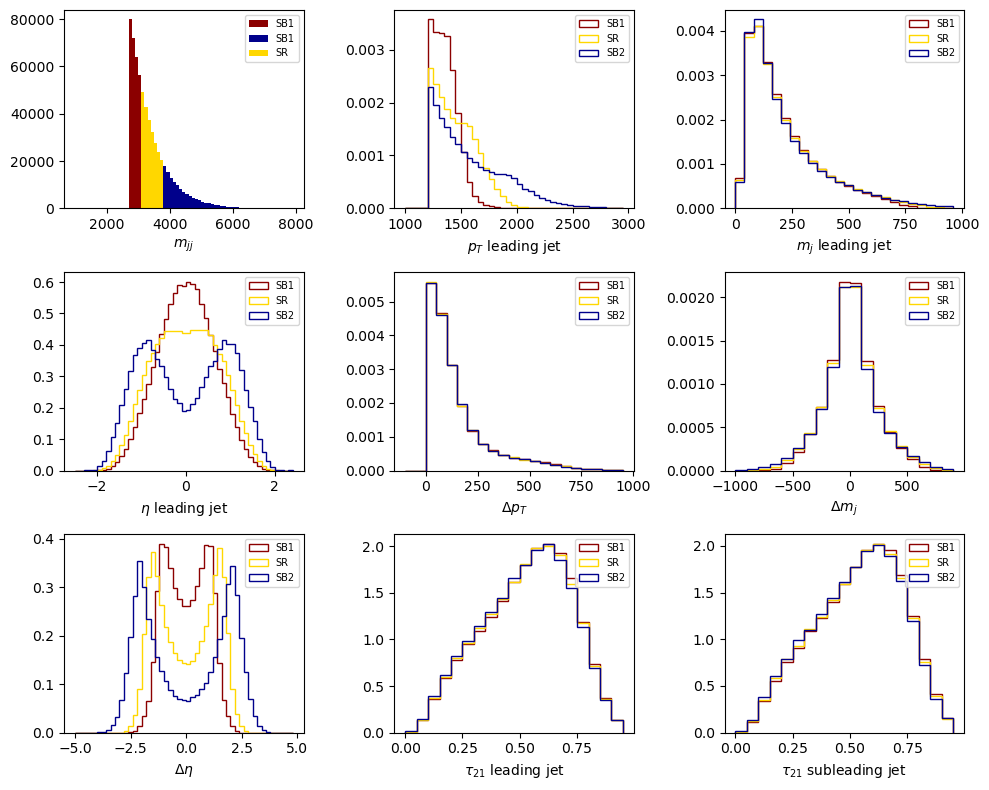

In [231]:

fig, axs = plt.subplots(3,3, figsize=(10, 8))

axs[0, 0].hist(high_level_features[SB1][...,1], bins=np.arange(1000, 8000, 100), histtype='stepfilled', color='darkred', label='SB1')
axs[0, 0].hist(high_level_features[SB2][...,1], bins=np.arange(1000, 8000, 100), histtype='stepfilled', color='darkblue', label='SB1')
axs[0, 0].hist(high_level_features[SR][...,1], bins=np.arange(1000, 8000, 100), histtype='stepfilled', color='gold', label='SR')
axs[0, 0].set_xlabel(r'$m_{jj}$')
axs[0, 0].legend(fontsize=7, loc='upper right')

axs[0, 1].hist(high_level_features[SB1][...,2], bins=np.arange(1000, 3000, 50), histtype='step', color='darkred', density=True, label='SB1')
axs[0, 1].hist(high_level_features[SR][...,2], bins=np.arange(1000, 3000, 50), histtype='step', color='gold', density=True, label='SR')
axs[0, 1].hist(high_level_features[SB2][...,2], bins=np.arange(1000, 3000, 50), histtype='step', color='darkblue', density=True, label='SB2')
axs[0, 1].set_xlabel(r'$p_{T}$ leading jet')
axs[0, 1].legend(fontsize=7, loc='upper right')

axs[0, 2].hist(high_level_features[SB1][...,3], bins=np.arange(0, 1000, 40), histtype='step', color='darkred', density=True, label='SB1')
axs[0, 2].hist(high_level_features[SR][...,3], bins=np.arange(0, 1000, 40), histtype='step', color='gold', density=True, label='SR')
axs[0, 2].hist(high_level_features[SB2][...,3], bins=np.arange(0, 1000, 40), histtype='step', color='darkblue', density=True, label='SB2')
axs[0, 2].set_xlabel(r'$m_j$ leading jet')
axs[0, 2].legend(fontsize=7, loc='upper right')

axs[1, 0].hist(high_level_features[SB1][...,4], bins=np.arange(-2.5, 2.5, 0.1), histtype='step', color='darkred', density=True, label='SB1')
axs[1, 0].hist(high_level_features[SR][...,4], bins=np.arange(-2.5, 2.5, 0.1), histtype='step', color='gold', density=True, label='SR')
axs[1, 0].hist(high_level_features[SB2][...,4], bins=np.arange(-2.5, 2.5, 0.1), histtype='step', color='darkblue',  density=True, label='SB2')
axs[1, 0].set_xlabel(r'$\eta$ leading jet')
axs[1, 0].legend(fontsize=7, loc='upper right')

axs[1, 1].hist(high_level_features[SB1][...,5], bins=np.arange(-100, 1000, 50), histtype='step', color='darkred', density=True, label='SB1')
axs[1, 1].hist(high_level_features[SR][...,5], bins=np.arange(-100, 1000, 50), histtype='step', color='gold', density=True, label='SR')
axs[1, 1].hist(high_level_features[SB2][...,5], bins=np.arange(-100, 1000, 50), histtype='step', color='darkblue', density=True, label='SB2')
axs[1, 1].set_xlabel(r'$\Delta p_{T}$')
axs[1, 1].legend(fontsize=7, loc='upper right')

axs[1, 2].hist(high_level_features[SB1][...,6], bins=np.arange(-1000, 1000, 100), histtype='step', color='darkred', density=True, label='SB1')
axs[1, 2].hist(high_level_features[SR][...,6], bins=np.arange(-1000, 1000, 100), histtype='step', color='gold', density=True, label='SR')
axs[1, 2].hist(high_level_features[SB2][...,6], bins=np.arange(-1000, 1000, 100), histtype='step', color='darkblue', density=True, label='SB2')
axs[1, 2].set_xlabel(r'$\Delta m_j$')
axs[1, 2].legend(fontsize=7, loc='upper right')

axs[2, 0].hist(high_level_features[SB1][...,7], bins=np.arange(-5, 5, 0.2), histtype='step', color='darkred', density=True, label='SB1')
axs[2, 0].hist(high_level_features[SR][...,7], bins=np.arange(-5, 5, 0.2), histtype='step', color='gold', density=True, label='SR')
axs[2, 0].hist(high_level_features[SB2][...,7], bins=np.arange(-5, 5, 0.2), histtype='step', color='darkblue',  density=True, label='SB2')
axs[2, 0].set_xlabel(r'$\Delta\eta$')
axs[2, 0].legend(fontsize=7, loc='upper right')

axs[2, 1].hist(high_level_features[SB1][...,8], bins=np.arange(0, 1, 0.05), histtype='step', color='darkred', density=True, label='SB1')
axs[2, 1].hist(high_level_features[SR][...,8], bins=np.arange(0, 1, 0.05), histtype='step', color='gold',  density=True, label='SR')
axs[2, 1].hist(high_level_features[SB2][...,8], bins=np.arange(0, 1, 0.05), histtype='step', color='darkblue',  density=True, label='SB2')
axs[2, 1].set_xlabel(r'$\tau_{21}$ leading jet')
axs[2, 1].legend(fontsize=7, loc='upper right')

axs[2, 2].hist(high_level_features[SB1][...,9], bins=np.arange(0, 1, 0.05), histtype='step', color='darkred', density=True, label='SB1')
axs[2, 2].hist(high_level_features[SR][...,9], bins=np.arange(0, 1, 0.05), histtype='step', color='gold', density=True, label='SR')
axs[2, 2].hist(high_level_features[SB2][...,9], bins=np.arange(0, 1, 0.05), histtype='step', color='darkblue',  density=True, label='SB2')
axs[2, 2].set_xlabel(r'$\tau_{21}$ subleading jet')
axs[2, 2].legend(fontsize=7, loc='upper right')

plt.tight_layout()
plt.show()


In [232]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def results_plots(sb1, sb2, sr, 
                  bins=[(2700, 8000, 100),(0, 1000, 50),(-1000, 1000, 100),(0, 1, 0.05),(0, 1, 0.05)], 
                  features=[r'$m_{jj}$', r'$m_j$', r'$\Delta m$', r'$\tau_{21}$ leading', r'$\tau_{21}$ subleading']):
    
    fig = plt.figure(figsize=(25, 5))
    gs = gridspec.GridSpec(2, 5, height_ratios=[5, 1])
    gs.update(hspace=0.1) 
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        b = bins[idx]
        SB1, Bins1, _ = ax.hist(sb1[..., idx], bins=np.arange(*b), color='darkred', histtype='step', lw=2, label='SB1', density=True)
        SB2, Bins2, _ = ax.hist(sb2[..., idx], bins=np.arange(*b), color='darkblue', histtype='step',  lw=2, label='SB2', density=True)
        SR, _, _ = ax.hist(sr[..., idx], bins=np.arange(*b), color='gold', histtype='step',  lw=2, label='SR', density=True)
        ax.set_xticklabels([])
        ax.set_xticks([])
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        else: ax.set_xlabel(feature)
        ax.legend(loc='upper right', fontsize=8)

        ax_ratio = fig.add_subplot(gs[idx + 5])
        ratio_1 = np.divide(SB1, SR, out=np.ones_like(SR), where=SR != 0)
        ratio_2 = np.divide(SB2, SR, out=np.ones_like(SR), where=SR != 0)
        ax_ratio.plot(0.5 * (Bins1[:-1] + Bins1[1:]), ratio_1, color='darkred', lw=1)
        ax_ratio.plot(0.5 * (Bins2[:-1] + Bins2[1:]), ratio_2, color='darkblue', lw=1)
        ax_ratio.set_ylim(0.5, 1.5) 
        ax_ratio.set_xlabel(feature)
        ax_ratio.axhline(1, color='gray', linestyle='--', lw=1)
        for tick in ax_ratio.xaxis.get_major_ticks():
            tick.label1.set_fontsize(7)  # Updated from tick.label.set_fontsize
        for tick in ax_ratio.yaxis.get_major_ticks():
            tick.label1.set_fontsize(5)  # Updated from tick.label.set_fontsize
        if idx == 0:
            ax_ratio.set_ylabel('SB/SR bkg', fontsize=8)
        ax_ratio.set_yticks([0.5, 1, 1.5])


    plt.tight_layout()
    plt.show()

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/1756861220.py:22: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/1756861220.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


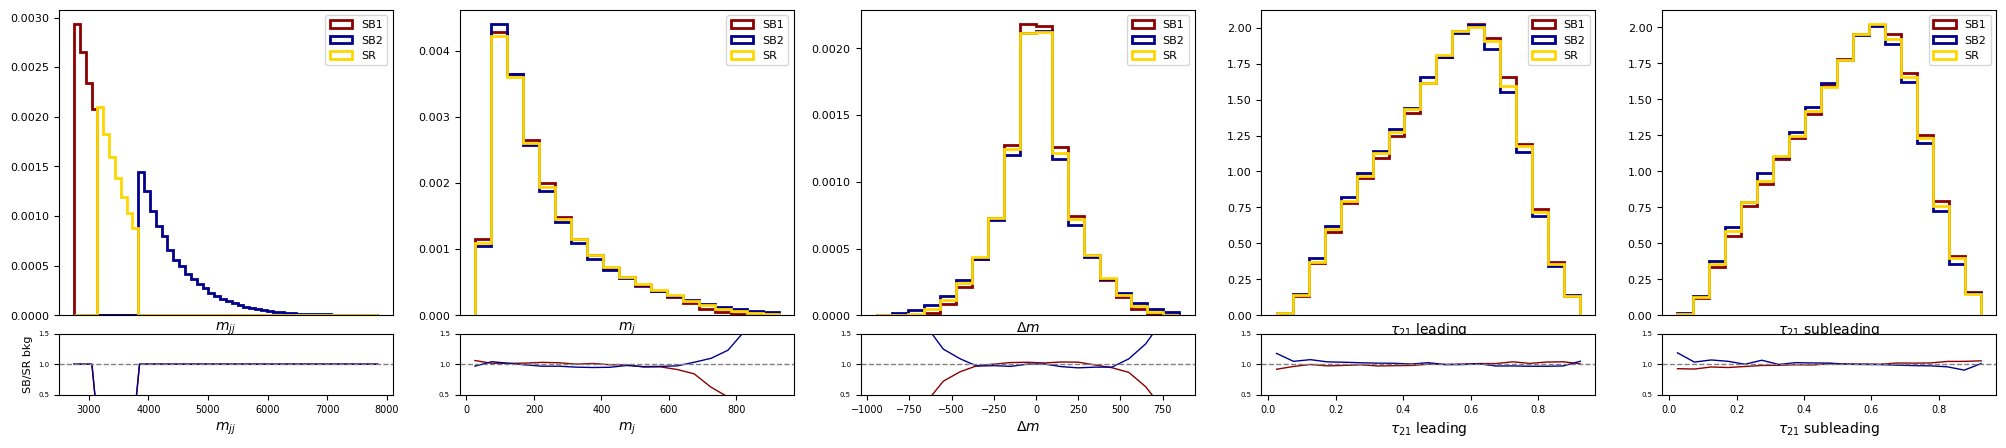

In [233]:
results_plots(sb1 , sb2, sr)

# Datasets

In [92]:
class LHCOlympicsDataset(Dataset):

    def __init__(self, preprocess=None):
        
        self.preprocess_methods = preprocess
        self.num_samples = 60000
        self.sideband_1 = {'mjj': [2700, 3100]}
        self.sideband_2 = {'mjj': [3900, 13000]}
        
        self.signal_region = {'mjj': [self.sideband_1['mjj'][1], self.sideband_2['mjj'][0]]}
        self.summary_stats = None
    
        ''' data attributes:
            - target: jetnet data
            - target_preprocessed:  jetnet data with preprocessing
            - source: std gaussian noise
        '''

        self.get_target_data()
        self.get_source_data()
        self.get_background_data()

    def __getitem__(self, idx):
        output = {}
        output['target'] = self.target_preprocess[idx]
        output['source'] = self.source_preprocess[idx]
        output['mask'] = torch.ones_like(self.target[idx][..., 0])
        output['context'] = torch.empty_like(self.target[idx][..., 0])
        return output


    def __len__(self):
        return self.dijets.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_target_data(self):
        file = '../data/LHCOlympics2020/events_anomalydetection_dijets.h5'
        f = h5py.File(file, 'r') 
        dijets = torch.Tensor(f['dijet features'])
        sb2 = PreProcessLHCOlympicsData(dijets,  num_samples=self.num_samples, cuts=self.sideband_2, methods=self.preprocess_methods)
        sb2.apply_cuts()
        self.target = sb2.features.clone()
        self.target_context = sb2.log_mjj.clone()
        sb2.preprocess()
        self.target_summary_stats = sb2.summary_stats
        self.target_preprocess = sb2.features.clone()
        f.close()

    def get_source_data(self):
        file = '../data/LHCOlympics2020/events_anomalydetection_dijets.h5'
        f = h5py.File(file, 'r') 
        dijets = torch.Tensor(f['dijet features'])
        sb1 = PreProcessLHCOlympicsData(dijets, num_samples=self.num_samples, cuts=self.sideband_1, methods=self.preprocess_methods)
        sb1.apply_cuts()
        self.source = sb1.features.clone()
        self.source_context = sb1.log_mjj.clone()
        sb1.preprocess()
        self.source_summary_stats = sb1.summary_stats
        self.source_preprocess = sb1.features.clone()
        f.close()

    def get_background_data(self):
        file = '../data/LHCOlympics2020/events_anomalydetection_dijets.h5'
        f = h5py.File(file, 'r') 
        dijets = torch.Tensor(f['dijet features'])
        sr = PreProcessLHCOlympicsData(dijets, num_samples=self.num_samples, cuts=self.signal_region, methods=self.preprocess_methods)
        sr.apply_cuts(background=True)
        self.background = sr.features.clone()
        self.background_context = sr.log_mjj.clone()
        sr.preprocess()
        self.background_summary_stats = sr.summary_stats
        self.background_preprocess = sr.features.clone()
        f.close()


class PreProcessLHCOlympicsData:

    def __init__(self, 
                 data, 
                 num_samples: int=None,
                 cuts: dict={'mjj': None},
                 methods: list=None
                 ):
        
        self.features = data
        self.cuts = cuts 
        self.num_samples = num_samples
        self.methods = methods
        self.summary_stats = {}

    def apply_cuts(self, background=False):
        self.selection_cuts(feature='mjj', cut=self.cuts['mjj'], background=background)

    def preprocess(self):        
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Preprocessing method {} not implemented'.format(method))
        else: pass
    
    def selection_cuts(self, feature, cut=None, background=False):
        if cut is None: cut=[-np.inf, np.inf]
        dic={'mjj':1}
        if background:
            self.features = self.features[self.features[...,0]==0]
        mask = (self.features[..., dic[feature]] >= cut[0]) & (self.features[..., dic[feature]] <= cut[1])
        self.features = self.features[mask]
        self.features = self.features[:self.num_samples]
        self.log_mjj = torch.log(self.features[..., 1])
        self.features = torch.cat([self.features[..., 3:7], self.features[..., 8:12]], dim=-1)  
        
    def log_pt(self):
        self.features[..., 0] = torch.log(self.features[..., 0])
        self.features[..., 4] = torch.log(self.features[..., 4])

    def log_mass(self):
        self.features[..., 3] = torch.log(self.features[..., 3]) + 2e-5
        self.features[..., 7] = torch.log(self.features[..., 7]) + 2e-5


lhco = LHCOlympicsDataset(preprocess=['log_pt', 'log_mass'])
lhco.source.shape, lhco.background.shape, lhco.target.shape, lhco.source_context.shape, lhco.background_context.shape, lhco.target_context.shape

(torch.Size([60000, 8]),
 torch.Size([60000, 8]),
 torch.Size([60000, 8]),
 torch.Size([60000]),
 torch.Size([60000]),
 torch.Size([60000]))

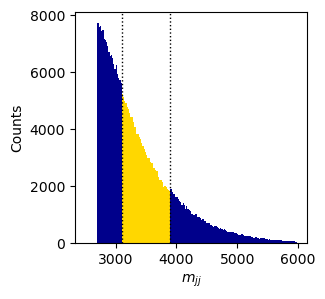

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
_ = axs.hist(torch.exp(lhco.source_context), bins=np.arange(2500,6000, 20), histtype='stepfilled', color='darkblue')
_ = axs.hist(torch.exp(lhco.target_context), bins=np.arange(2500,6000, 20), histtype='stepfilled', color='darkblue')
_ = axs.hist(torch.exp(lhco.background_context), bins=np.arange(2500,6000, 20), histtype='stepfilled', color='gold')
#vertical line
_ = axs.axvline(x=3100, color='black', linestyle=':', lw=1)
_ = axs.axvline(x=3900, color='black', linestyle=':', lw=1)
_ = axs.set_xlabel(r'$m_{jj}$')
_ = axs.set_ylabel('Counts')

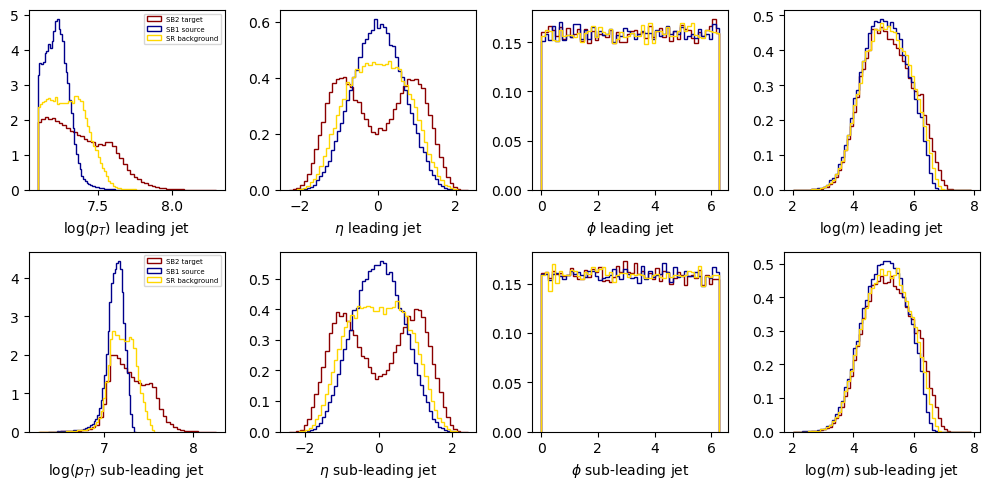

In [101]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
axs[0,0].hist(lhco.target_preprocess[...,0], bins=50, histtype='step', color='darkred', density=True, label='SB2 target')
axs[0,0].hist(lhco.source_preprocess[...,0], bins=50, histtype='step', color='darkblue', density=True, label='SB1 source')
axs[0,0].hist(lhco.background_preprocess[...,0], bins=50, histtype='step', color='gold', density=True, label='SR background')
axs[0,0].set_xlabel(r'$\log(p_T)$ leading jet')
axs[0,0].legend(fontsize=5, loc='upper right')
axs[0,1].hist(lhco.target_preprocess[...,1], bins=50, histtype='step', color='darkred', density=True)
axs[0,1].hist(lhco.source_preprocess[...,1], bins=50, histtype='step', color='darkblue', density=True)
axs[0,1].hist(lhco.background_preprocess[...,1], bins=50, histtype='step', color='gold', density=True)
axs[0,1].set_xlabel(r'$\eta$ leading jet')
axs[0,2].hist(lhco.target_preprocess[...,2], bins=50, histtype='step', color='darkred', density=True)
axs[0,2].hist(lhco.source_preprocess[...,2], bins=50, histtype='step', color='darkblue', density=True)
axs[0,2].hist(lhco.background_preprocess[...,2], bins=50, histtype='step', color='gold', density=True)
axs[0,2].set_xlabel(r'$\phi$ leading jet')
axs[0,3].hist(lhco.target_preprocess[...,3], bins=np.arange(2,8,0.1), histtype='step', color='darkred', density=True)
axs[0,3].hist(lhco.source_preprocess[...,3], bins=np.arange(2,8,0.1), histtype='step', color='darkblue', density=True)
axs[0,3].hist(lhco.background_preprocess[...,3], bins=np.arange(2,8,0.1), histtype='step', color='gold', density=True)
axs[0,3].set_xlabel(r'$\log(m)$ leading jet')

axs[1,0].hist(lhco.target_preprocess[...,4], bins=50, histtype='step', color='darkred', density=True, label='SB2 target')
axs[1,0].hist(lhco.source_preprocess[...,4], bins=50, histtype='step', color='darkblue', density=True, label='SB1 source')
axs[1,0].hist(lhco.background_preprocess[...,4], bins=50, histtype='step', color='gold', density=True, label='SR background')
axs[1,0].set_xlabel(r'$\log(p_T)$ sub-leading jet')
axs[1,0].legend(fontsize=5, loc='upper right')
axs[1,1].hist(lhco.target_preprocess[...,5], bins=50, histtype='step', color='darkred', density=True)
axs[1,1].hist(lhco.source_preprocess[...,5], bins=50, histtype='step', color='darkblue', density=True)
axs[1,1].hist(lhco.background_preprocess[...,5], bins=50, histtype='step', color='gold', density=True)
axs[1,1].set_xlabel(r'$\eta$ sub-leading jet')
axs[1,2].hist(lhco.target_preprocess[...,6], bins=50, histtype='step', color='darkred', density=True)
axs[1,2].hist(lhco.source_preprocess[...,6], bins=50, histtype='step', color='darkblue', density=True)
axs[1,2].hist(lhco.background_preprocess[...,6], bins=50, histtype='step', color='gold', density=True)
axs[1,2].set_xlabel(r'$\phi$ sub-leading jet')
axs[1,3].hist(lhco.target_preprocess[...,7], bins=np.arange(2,8,0.1), histtype='step', color='darkred', density=True)
axs[1,3].hist(lhco.source_preprocess[...,7], bins=np.arange(2,8,0.1), histtype='step', color='darkblue', density=True)
axs[1,3].hist(lhco.background_preprocess[...,7], bins=np.arange(2,8,0.1), histtype='step', color='gold', density=True)
axs[1,3].set_xlabel(r'$\log(m)$ sub-leading jet')
plt.tight_layout()
plt.show()

array([[ 7.4993086 ,  0.89457357,  3.2527986 ,  4.6933713 ],
       [ 7.4659457 , -0.5127786 ,  0.65666884,  6.3528223 ],
       [ 7.1054063 , -1.5634587 ,  1.5192167 ,  5.4993577 ],
       ...,
       [ 7.177462  , -0.27018002,  1.9708985 ,  4.4023004 ],
       [ 7.741623  ,  0.37253097,  3.1753469 ,  5.018727  ],
       [ 7.1106524 , -1.1885105 ,  5.6072326 ,  5.1007195 ]],
      dtype=float32)